In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Load clean data and prepare the same single item as before
sales_clean = pd.read_parquet('../data/sales_clean.parquet')

product_id = 'HOBBIES_1_001'
store_id = 'CA_1'

single_item = sales_clean[
    (sales_clean['item_id'] == product_id) &
    (sales_clean['store_id'] == store_id)
].copy()

# Prepare for Prophet
df_prophet = single_item[['date', 'sales']].rename(columns={
    'date': 'ds',
    'sales': 'y'
}).reset_index(drop=True)

# Train model and generate forecast
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

print("Model ready!")
print("Forecast tail:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5))

Importing plotly failed. Interactive plots will not work.
14:01:39 - cmdstanpy - INFO - Chain [1] start processing
14:01:39 - cmdstanpy - INFO - Chain [1] done processing


Model ready!
Forecast tail:
             ds      yhat  yhat_lower  yhat_upper
1102 2016-07-19  0.839019   -0.148341    1.988489
1103 2016-07-20  0.627113   -0.471223    1.728324
1104 2016-07-21  0.616007   -0.464032    1.636413
1105 2016-07-22  0.723024   -0.296884    1.740120
1106 2016-07-23  1.006027    0.042442    1.995017


In [3]:
# ── Inventory Parameters ──────────────────────────────────────────────────
# These would come from a real business in practice
lead_time_days = 7        # Days between placing and receiving an order
service_level = 0.95      # 95% service level (z-score = 1.645)
holding_cost = 0.20       # 20% of item value per year to hold inventory
ordering_cost = 10.00     # Fixed cost per order placed
z_score = 1.645           # Corresponds to 95% service level

# ── Pull forecast values for the next 90 days ─────────────────────────────
future_forecast = forecast[forecast['ds'] > df_prophet['ds'].max()].copy()

# Clip negative forecast values to 0 (sales can't be negative)
future_forecast['yhat'] = future_forecast['yhat'].clip(lower=0)
future_forecast['yhat_upper'] = future_forecast['yhat_upper'].clip(lower=0)
future_forecast['yhat_lower'] = future_forecast['yhat_lower'].clip(lower=0)

# ── Core calculations ─────────────────────────────────────────────────────
avg_daily_demand = future_forecast['yhat'].mean()
std_daily_demand = future_forecast['yhat'].std()
avg_price = single_item['sell_price'].mean()

# Safety Stock = Z * std(demand) * sqrt(lead time)
safety_stock = z_score * std_daily_demand * np.sqrt(lead_time_days)

# Reorder Point = (avg daily demand * lead time) + safety stock
rop = (avg_daily_demand * lead_time_days) + safety_stock

# EOQ = sqrt((2 * annual demand * ordering cost) / (holding cost * item price))
annual_demand = avg_daily_demand * 365
eoq = np.sqrt((2 * annual_demand * ordering_cost) / (holding_cost * avg_price))

print(f"Product: {product_id} at {store_id}")
print(f"─────────────────────────────────────")
print(f"Avg Daily Demand:   {avg_daily_demand:.2f} units/day")
print(f"Std Daily Demand:   {std_daily_demand:.2f} units/day")
print(f"Avg Sell Price:     ${avg_price:.2f}")
print(f"─────────────────────────────────────")
print(f"Safety Stock:       {safety_stock:.1f} units")
print(f"Reorder Point:      {rop:.1f} units")
print(f"EOQ:                {eoq:.1f} units")

Product: HOBBIES_1_001 at CA_1
─────────────────────────────────────
Avg Daily Demand:   0.64 units/day
Std Daily Demand:   0.23 units/day
Avg Sell Price:     $8.28
─────────────────────────────────────
Safety Stock:       1.0 units
Reorder Point:      5.5 units
EOQ:                53.1 units


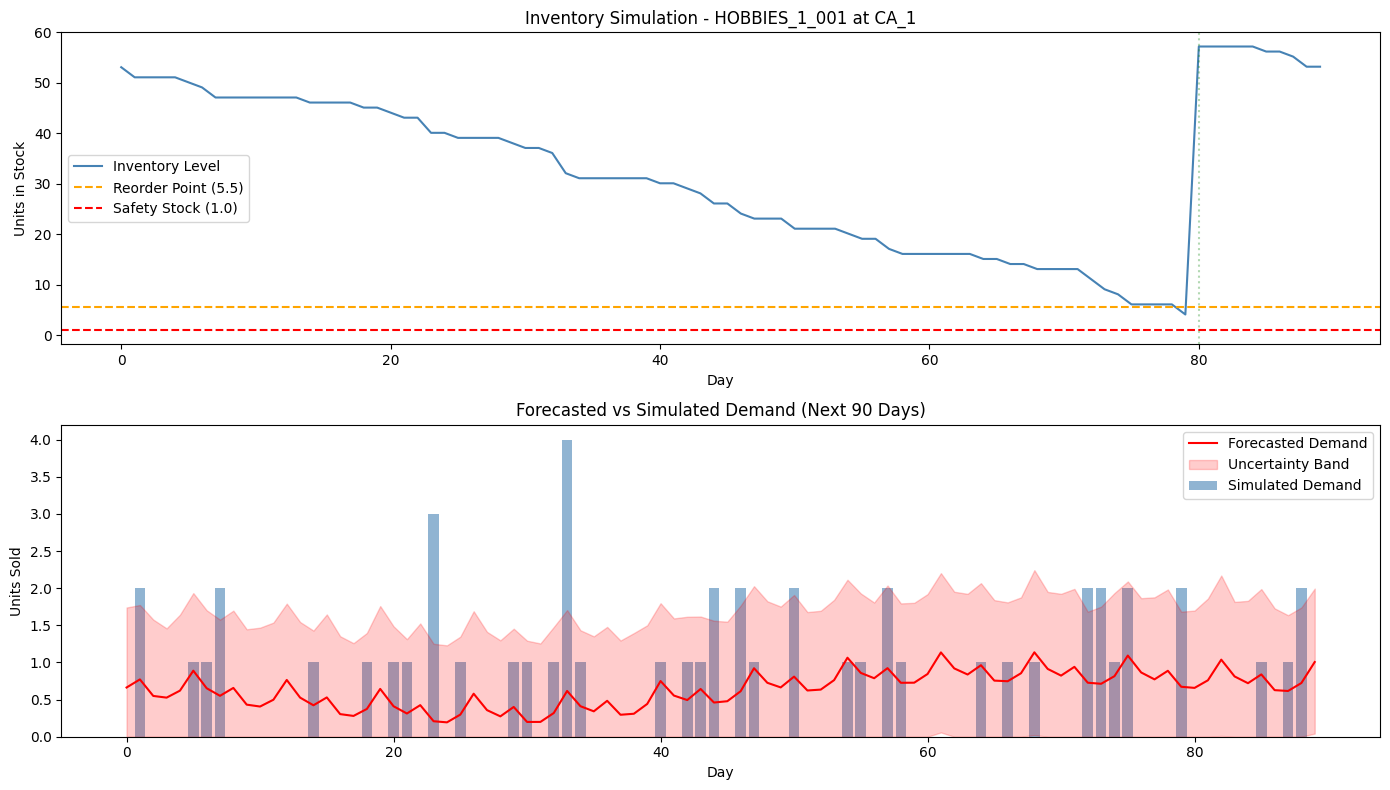

In [4]:
# Simulate inventory level over the 90 day forecast period
np.random.seed(42)
simulated_demand = np.random.poisson(avg_daily_demand, size=90)

inventory = []
current_inventory = eoq  # Start with one full order
orders = []

for day, demand in enumerate(simulated_demand):
    # Check if we need to reorder
    if current_inventory <= rop:
        current_inventory += eoq
        orders.append(day)
    
    # Fulfill demand
    current_inventory = max(0, current_inventory - demand)
    inventory.append(current_inventory)

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Inventory simulation
ax1.plot(inventory, label='Inventory Level', color='steelblue')
ax1.axhline(y=rop, color='orange', linestyle='--', label=f'Reorder Point ({rop:.1f})')
ax1.axhline(y=safety_stock, color='red', linestyle='--', label=f'Safety Stock ({safety_stock:.1f})')
for order in orders:
    ax1.axvline(x=order, color='green', alpha=0.3, linestyle=':')
ax1.set_title(f'Inventory Simulation - {product_id} at {store_id}')
ax1.set_xlabel('Day')
ax1.set_ylabel('Units in Stock')
ax1.legend()

# Forecasted demand
ax2.bar(range(90), simulated_demand, color='steelblue', alpha=0.6, label='Simulated Demand')
ax2.plot(future_forecast['yhat'].values, color='red', label='Forecasted Demand')
ax2.fill_between(range(90),
                  future_forecast['yhat_lower'].values,
                  future_forecast['yhat_upper'].values,
                  alpha=0.2, color='red', label='Uncertainty Band')
ax2.set_title('Forecasted vs Simulated Demand (Next 90 Days)')
ax2.set_xlabel('Day')
ax2.set_ylabel('Units Sold')
ax2.legend()

plt.tight_layout()
plt.show()